# Getting started

## Stacking

> https://juliaai.github.io/DataScienceTutorials.jl/getting-started/stacking/
> <br> **(project folder)** https://raw.githubusercontent.com/juliaai/DataScienceTutorials.jl/gh-pages/__generated/A-stacking.tar.gz

In [1]:
using Pkg ; Pkg.activate("D:/JULIA/6_ML_with_Julia/A-stacking"); Pkg.instantiate()

  Activating project at `D:\JULIA\6_ML_with_Julia\A-stacking`


> Basic stacking using out-of-sample base learner predictions
> 1. Warm-up exercise: Define a model type to average predictions
> Stacking proper
> 1. Helper functions:
> 2. Choose some test data (optional) and some component models (defaults for the composite model):
> 3. Define the training nodes
> 4. Define nodes still needed for prediction
>
> Export the learning network as a new model type <br>
> Applying MyTwoModelStack to some data

In stacking one blends the predictions of different regressors or classifiers to gain, in some cases, better performance than naive averaging or majority vote.

For routine stacking tasks the MLJ user should use the ```Stack``` model documented here. In this tutorial we build a two-model stack as an MLJ learning network, which we export as a new stand-alone composite model type ```MyTwoStack```. The objective of this tutorial is to: (i) Explain with julia code how stacking works; and (ii) Give an advanced demonstration of MLJ's composite model interface.

As we shall see, as a new stand-alone model type, we can apply the usual meta-algorithms, such as performance evaluation and tuning, to ```MyTwoStack```.

### Basic stacking using out-of-sample base learner predictions

---

A rather general stacking protocol was first described in a 1992 paper by David Wolpert. For a generic introduction to the basic two-layer stack described here, see this blog post of Burak Himmetoglu.

A basic stack consists of a number of base learners (two, in this illustration) and a single adjudicating model.

When a stacked model is called to make a prediction, the individual predictions of the base learners are made the columns of an input table for the adjudicating model, which then outputs the final prediction. However, it is crucial to understand that the flow of data during training is not the same.

The base model predictions used to train the adjudicating model are not the predictions of the base learners fitted to all the training data. Rather, to prevent the adjudicator giving too much weight to the base learners with low training error, the input data is first split into a number of folds (as in cross-validation), a base learner is trained on each fold complement individually, and corresponding predictions on the folds are spliced together to form a full-length prediction called the out-of-sample prediction.

For illustrative purposes we use just three folds. Each base learner will get three separate machines, for training on each fold complement, and a fourth machine, trained on all the supplied data, for use in the prediction flow.

We build the learning network with dummy data at the source nodes, so the reader inspects the workings of the network as it is built (by calling ```fit!``` on nodes, and by calling the nodes themselves). As usual, this data is not seen by the exported composite model type, and the component models we choose are just default values for the hyperparameters of the composite model.

In [2]:
using MLJ
using PyPlot
using StableRNGs

Some models we will use:

In [3]:
linear = (@load LinearRegressor pkg=MLJLinearModels)()
knn = (@load KNNRegressor)()

tree_booster = (@load EvoTreeRegressor)()
forest = (@load RandomForestRegressor pkg = DecisionTree)()
svm = (@load SVMRegressor)()

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168


import MLJLinearModels ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168


import NearestNeighborModels ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168


import EvoTrees ✔
import MLJDecisionTreeInterface ✔

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168


import MLJScikitLearnInterface ✔


SVMRegressor(
    kernel = "rbf",
    degree = 3,
    gamma = "auto",
    coef0 = 0.0,
    tol = 0.001,
    C = 1.0,
    epsilon = 0.1,
    shrinking = true,
    cache_size = 200,
    max_iter = -1)

### Warm-up exercise: Define a model type to average predictions
---

Let's define a composite model type ```MyAverageTwo``` that averages the predictions of two deterministic regressors. Here's the learning network:

In [4]:
X = source()
y = source()

model1 = linear
model2 = knn

m1 = machine(model1, X, y)
y1 = predict(m1, X)

m2 = machine(model2, X, y)
y2 = predict(m2, X)

yhat = 0.5*y1 + 0.5*y2

Node{Nothing}
  args:
    1:	Node{Nothing}
    2:	Node{Nothing}
  formula:
    +(
        #100(
            predict(
                Machine{LinearRegressor,…}, 
                Source @545)),
        #100(
            predict(
                Machine{KNNRegressor,…}, 
                Source @545)))

In preparation for export, we wrap the learning network in a learning network machine, which specifies what the source nodes are, and which node is for prediction. As our exported model will make point-predictions (as opposed to probabilistic ones), we use a ```Deterministic``` "surrogate" model:

In [5]:
mach = machine(Deterministic(), X, y; predict = yhat)

Machine{DeterministicSurrogate,…} trained 0 times; does not cache data
  model: DeterministicSurrogate
  args: 
    1:	Source @545 ⏎ `Nothing`
    2:	Source @590 ⏎ `Nothing`


Note that we cannot actually fit this machine because we chose not to wrap our source nodes ```X``` and ```y``` in data.

Here's the macro call that "exports" the learning network as a new composite model ```MyAverageTwo```:

In [6]:
@from_network mach begin 
    mutable struct MyAverageTwo
        regressor1 = model1
        regressor2 = model2
    end
end

Note that, unlike a normal struct definition, the defaults ```model1``` and ```model2``` must be specified, and they must refer to model instances in the learning network.

We can now create an instance of the new type:

In [7]:
average_two = MyAverageTwo()

MyAverageTwo(
    regressor1 = LinearRegressor(
            fit_intercept = true,
            solver = nothing),
    regressor2 = KNNRegressor(
            K = 5,
            algorithm = :kdtree,
            metric = Distances.Euclidean(0.0),
            leafsize = 10,
            reorder = true,
            weights = NearestNeighborModels.Uniform()))

Evaluating this average model on the Boston data set, and comparing with the base model predictions:

In [8]:
function print_performance(model, data...)
    e = evaluate(model, data...;
                resampling=CV(rng=StableRNG(1234), nfolds = 8),
                measure = rms,
                verbosity = 0)
    μ= round(e.measurement[1], sigdigits = 5)
    ste = round(std(e.per_fold[1])/sqrt(8), digits = 5)
    println("$model = $μ ± $(2*ste)")
end;

X, y = @load_boston

print_performance(linear, X, y)
print_performance(knn, X, y)
print_performance(average_two, X, y)

LinearRegressor = 4.8635 ± 0.34864
KNNRegressor = 6.2243 ± 0.44292
MyAverageTwo = 4.8523 ± 0.36264


### Stacking proper
---

### Helper functions:

To generate folds for generating out-of-sample predictions, we define

In [9]:
folds(data, nfolds) = partition(1:nrows(data), (1/nfolds for i in 1:(nfolds-1))...);

For example, we have:

In [10]:
f = folds(1:10, 3)

([1, 2, 3], [4, 5, 6], [7, 8, 9, 10])

It will also be convenient to use the MLJ method ```restrict(X, f, i)``` that restricts data ```X``` to the ```i```th element (fold) of ```f```, and ```corestrict(X, f, i)``` that restricts to the corresponding fold complement (the concatenation of all but the ```i```th fold).

For example, we have:

In [11]:
corestrict(string.(1:10), f, 2)

7-element Vector{String}:
 "1"
 "2"
 "3"
 "7"
 "8"
 "9"
 "10"

### Choose some data (optional) and some component models (defaults for the composite model):

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\jeffr\.julia\packages\PyCall\L0fLP\src\numpy.jl:67


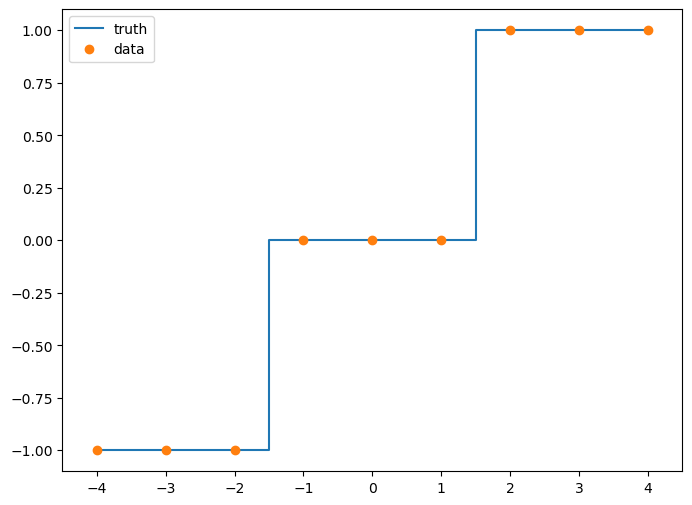

In [12]:
figure(figsize = (8,6))
steps(x) = x < -3/2 ? -1 : (x < 3/2 ? 0 : 1)
x = Float64[-4, -1, 2, -3, 0, 3, -2, 1, 4]
Xraw = (x = x, )
yraw = steps.(x);

idxsort = sortperm(x)
xsort = x[idxsort]
ysort = yraw[idxsort]
step(xsort, ysort, label = "truth", where = "mid")
plot(x, yraw, ls = "none", marker = "o", label = "data")
xlim(-4.5, 4.5)
legend()

savefig("./plots/2.10.1.png")

Some models to stack (which we can change later):

In [13]:
model1 = linear
model2 = knn

KNNRegressor(
    K = 5,
    algorithm = :kdtree,
    metric = Distances.Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = NearestNeighborModels.Uniform())

The adjudicating model:

In [14]:
judge = linear

LinearRegressor(
    fit_intercept = true,
    solver = nothing)

### Define the training nodes

Let's instantiate some input and target source nodes for the learning network, wrapping the play data defined above in source nodes:

In [15]:
X = source(Xraw)
y = source(yraw)

Source @253 ⏎ `AbstractVector{Count}`

Our first internal node will represent the three folds (vectors of row indices) for creating the out-of-sample predictions. We would like to define ```f = folds(X, 3)``` but this will not work because X is not a table, just a node representing a table. We could fix this by using the ```@node macro```:

In [16]:
f = @node folds(X, 3)# data type을 맞춰주기 위해 node macro로 변환

Node{Nothing}
  args:
    1:	Source @120
  formula:
    #10(
        Source @120)

Now ```f``` is itself a node, and so callable:

In [17]:
f()

([1, 2, 3], [4, 5, 6], [7, 8, 9])

However, we can also just overload ```folds``` to work on nodes, using the ```node``` function:

In [18]:
folds(X::AbstractNode, nfolds) = node(XX -> folds(XX, nfolds), X)
f = folds(X, 3)
f()

([1, 2, 3], [4, 5, 6], [7, 8, 9])

In the case of ```restrict``` and ```corestrict```, which also don't operate on nodes, method overloading will save us writing ```@node``` all the time:

In [19]:
MLJ.restrict(X::AbstractNode, f::AbstractNode, i) = node((XX, ff) -> restrict(XX, ff, i), X, f);
MLJ.corestrict(X::AbstractNode, f::AbstractNode, i) = node((XX, ff) -> corestrict(XX, ff, i), X, f);

We are now ready to define machines for training ```model1``` on each fold-complement:

In [20]:
m11 = machine(model1, corestrict(X, f, 1), corestrict(y, f, 1))
m12 = machine(model1, corestrict(X, f, 2), corestrict(y, f, 2))
m13 = machine(model1, corestrict(X, f, 3), corestrict(y, f, 3))

Machine{LinearRegressor,…} trained 0 times; caches data
  model: MLJLinearModels.LinearRegressor
  args: 
    1:	Node{Nothing}
    2:	Node{Nothing}


Define each out-of-sample prediction of ```model1```:

In [21]:
y11 = predict(m11, restrict(X, f, 1));
y12 = predict(m12, restrict(X, f, 2));
y13 = predict(m13, restrict(X, f, 3));

Splice together the out-of-sample predictions for model1:

In [22]:
y1_oos = vcat(y11, y12, y13);

Note there is no need to overload the ```vcat``` function to work on nodes; it does so out of the box, as does ```hcat``` and basic arithmetic operations.

Since our source nodes are wrapping data, we can optionally check our network so far, by calling fitting and calling ```y1_oos```:

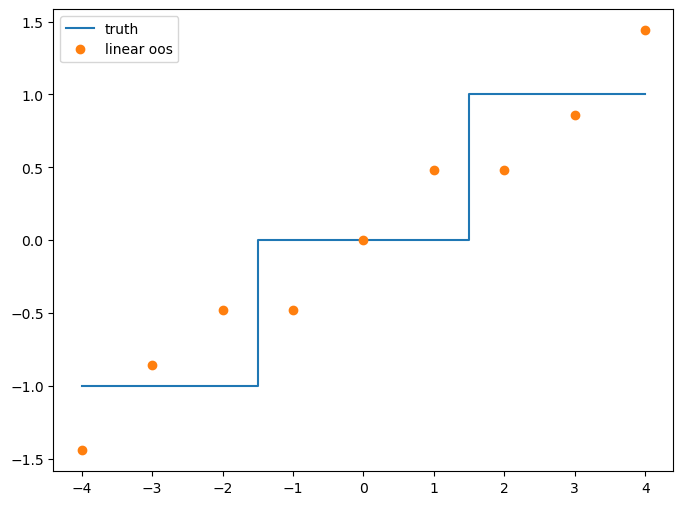

In [23]:
fit!(y1_oos, verbosity = 0)
figure(figsize = (8,6))
step(xsort, ysort, label = "truth", where="mid")
plot(x, y1_oos(), ls="none", marker = "o", label = "linear oos")
legend()

savefig("./plots/2.10.2.png")

We now repeat the procedure for the other model:

In [24]:
m21 = machine(model2, corestrict(X, f, 1), corestrict(y, f, 1))
m22 = machine(model2, corestrict(X, f, 2), corestrict(y, f, 2))
m23 = machine(model2, corestrict(X, f, 3), corestrict(y, f, 3))

y21 = predict(m21, restrict(X, f, 1));
y22 = predict(m21, restrict(X, f, 2));
y23 = predict(m21, restrict(X, f, 3));

And testing the knn out-of-sample prediction:

In [25]:
y2_oos = vcat(y21, y22, y23);
fit!(y2_oos, verbosity = 0)

Node{Nothing}
  args:
    1:	Node{Machine{KNNRegressor,…}}
    2:	Node{Machine{KNNRegressor,…}}
    3:	Node{Machine{KNNRegressor,…}}
  formula:
    vcat(
        predict(
            Machine{KNNRegressor,…}, 
            #14(
                Source @120,
                #12(
                    Source @120))),
        predict(
            Machine{KNNRegressor,…}, 
            #14(
                Source @120,
                #12(
                    Source @120))),
        predict(
            Machine{KNNRegressor,…}, 
            #14(
                Source @120,
                #12(
                    Source @120))))

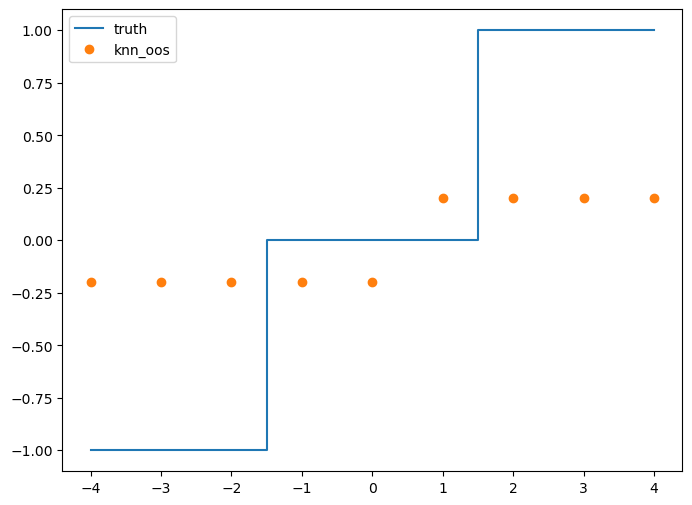

In [26]:
figure(figsize = (8,6))
step(xsort, ysort, label = "truth", where = "mid")
plot(x, y2_oos(), ls="none", marker="o", label = "knn_oos")
legend()

savefig("./plots/2.10.3.png")

Now that we have the out-of-sample base learner predictions, we are ready to merge them into the adjudicator's input table and construct the machine for training the adjudicator:

In [27]:
X_oos = MLJ.table(hcat(y1_oos, y2_oos))
m_judge = machine(judge, X_oos, y)

Machine{LinearRegressor,…} trained 0 times; caches data
  model: MLJLinearModels.LinearRegressor
  args: 
    1:	Node{Nothing}
    2:	Source @253 ⏎ `AbstractVector{Count}`


Are we done with constructing machines? Well, not quite. Recall that when we use the stack to make predictions on new data, we will be feeding the adjudicator ordinary predictions of the base learners (rather than out-of-sample predictions). But so far, we have only defined machines to train the base learners on fold complements, not on the full data, which we do now:

In [28]:
m1 = machine(model1, X, y)
m2 = machine(model2, X, y)

Machine{KNNRegressor,…} trained 0 times; caches data
  model: NearestNeighborModels.KNNRegressor
  args: 
    1:	Source @120 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @253 ⏎ `AbstractVector{Count}`


### Define nodes still needed for prediction

---

To obtain the final prediction, ```yhat```, we get the base learner predictions, based on training with all data, and feed them to the adjudicator:

In [29]:
y1 = predict(m1, X);
y2 = predict(m2, X);
X_judge = MLJ.table(hcat(y1, y2))
yhat = predict(m_judge, X_judge)

Node{Machine{LinearRegressor,…}}
  args:
    1:	Node{Nothing}
  formula:
    predict(
        Machine{LinearRegressor,…}, 
        table(
            hcat(
                predict(
                    Machine{LinearRegressor,…}, 
                    Source @120),
                predict(
                    Machine{KNNRegressor,…}, 
                    Source @120))))

Let's check the final prediction node can be fit and called:

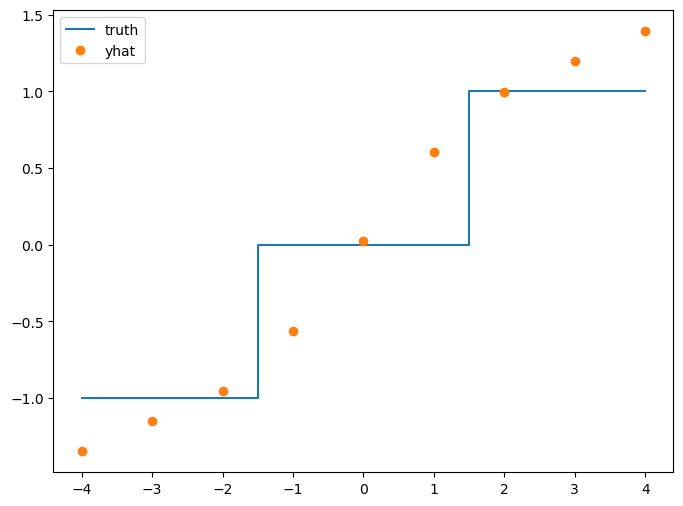

In [30]:
fit!(yhat, verbosity = 0)

figure(figsize = (8, 6))
step(xsort, ysort, label = "truth", where = "mid")
plot(x, yhat(), ls = "none", marker = "o", label = "yhat")
legend()

savefig("./plots/2.10.4.png")

Although of little statistical significance here, we note that stacking gives a lower training error than naive averaging:

In [31]:
e1 = rms(y1(), y())
e2 = rms(y2(), y())
emean = rms(0.5*y1() + 0.5*y2(), y())
estack = rms(yhat(), y())
@show e1 e2 emean estack;

e1 = 0.2581988897471611
e2 = 0.3771236166328254
emean = 0.2808716591058786
estack = 0.33739082156363265


### Export the learning network as a new model type

---

The learning network (less the data wrapped in the source nodes) amounts to a specification of a new composite model type for two-model stacks, trained with three-fold resampling of base model predictions. Let's create the new type ```MyTwoModelStack```, in the same way we exported the network for model averaging:

In [32]:
@from_network machine(Deterministic(), X, y; predict = yhat) begin
    mutable struct MyTwoModelStack
        regressor1 = model1
        regressor2 = model2
        judge = judge
    end
end

my_two_model_stack = MyTwoModelStack()

MyTwoModelStack(
    regressor1 = LinearRegressor(
            fit_intercept = true,
            solver = nothing),
    regressor2 = KNNRegressor(
            K = 5,
            algorithm = :kdtree,
            metric = Distances.Euclidean(0.0),
            leafsize = 10,
            reorder = true,
            weights = NearestNeighborModels.Uniform()),
    judge = LinearRegressor(
            fit_intercept = true,
            solver = nothing))

And this completes the definition of our re-usable stacking model type.

### Applying ```MyTowModelStack``` to some data

---

Without undertaking any hyperparameter optimization, we evaluate the performance of a tree boosting algorithm and a support vector machine on a synthetic data set. As adjudicator, we'll use a random forest.

We use a synthetic set to give an example where stacking is effective but the data is not too large. (As synthetic data is based on perturbations to linear models, we are deliberately avoiding linear models in stacking illustration.)

(주: 데이터를 regression 모델을 이용해 만들었으므로 regression 모델을 피한다.)

In [33]:
X, y = make_regression(1000, 20; sparse = 0.75, noise = 0.1, rng = 123);

### Define the stack and compare performance

In [34]:
avg = MyAverageTwo(regressor1 = tree_booster, regressor2 = svm)
stack = MyTwoModelStack(regressor1 = tree_booster, regressor2 = svm, judge = forest)

MyTwoModelStack(
    regressor1 = EvoTreeRegressor(
            loss = EvoTrees.Linear(),
            nrounds = 10,
            λ = 0.0,
            γ = 0.0,
            η = 0.1,
            max_depth = 5,
            min_weight = 1.0,
            rowsample = 1.0,
            colsample = 1.0,
            nbins = 64,
            α = 0.5,
            metric = :mse,
            rng = Random.MersenneTwister(123),
            device = "cpu"),
    regressor2 = SVMRegressor(
            kernel = "rbf",
            degree = 3,
            gamma = "auto",
            coef0 = 0.0,
            tol = 0.001,
            C = 1.0,
            epsilon = 0.1,
            shrinking = true,
            cache_size = 200,
            max_iter = -1),
    judge = RandomForestRegressor(
            max_depth = -1,
            min_samples_leaf = 1,
            min_samples_split = 2,
            min_purity_increase = 0.0,
            n_subfeatures = -1,
            n_trees = 10,
            sampling_fraction = 

In [35]:
all_models = [tree_booster, svm, forest, avg, stack];

for model in all_models
    print_performance(model, X, y)
end

EvoTreeRegressor{Float64,…} = 1.9206 ± 0.04474
SVMRegressor = 0.93596 ± 0.06682
RandomForestRegressor = 1.7005 ± 0.0615
MyAverageTwo = 1.3106 ± 0.0655
MyTwoModelStack = 0.87009 ± 0.04614


### Tuning a stack

A standard abuse of good data hygiene is to optimize stack component models separately and then tune the adjudicating model hyperparameters (using the same resampling of the data) with the base learners fixed. Although more computationally expensive, better generalization might be expected by applying tuning to the stack as a whole, either simultaneously, or in in cheaper sequential steps. Since our stack is a stand-alone model, this is readily implemented.

As a proof of concept, let's see how to tune one of the base model hyperparameters, based on performance of the stack as a whole:

In [36]:
r = range(stack, :(regressor2.C), lower = 0.01, upper = 10, scale = :log)
tuned_stack = TunedModel(model = stack,
                        ranges = r,
                        tuning = Grid(shuffle = false), 
                        measure = rms, 
                        resampling = Holdout())

DeterministicTunedModel(
    model = MyTwoModelStack(
            regressor1 = EvoTreeRegressor{Float64,…},
            regressor2 = SVMRegressor,
            judge = RandomForestRegressor),
    tuning = Grid(
            goal = nothing,
            resolution = 10,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    resampling = Holdout(
            fraction_train = 0.7,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = RootMeanSquaredError(),
    weights = nothing,
    operation = nothing,
    range = NumericRange(0.01 ≤ regressor2.C ≤ 10.0; origin=5.005, unit=4.995) on log scale,
    selection_heuristic = MLJTuning.NaiveSelection(nothing),
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = CPU1{Nothing}(nothing),
    acceleration_resampling = CPU1{Nothing}(nothing),
    check_measure = true,
    cache = true)

In [37]:
mach = fit!(machine(tuned_stack, X, y), verbosity = 0)
best_stack = fitted_params(mach).best_model
best_stack.regressor2.C

10.000000000000002

Let's evaluate the best stack using the same data resampling used to the evaluate the various untuned models earlier (now we are neglecting data hygiene!):

In [38]:
print_performance(best_stack, X, y)

MyTwoModelStack = 0.823 ± 0.05852
